<a href="https://colab.research.google.com/github/kangdoung/CS114.K21/blob/master/Do_an_cuoi_ky/Classify_face_celeb_svc_and_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bài toán nhận dạng người nổi tiếng**
* Input: ảnh của 1 trong 5 người  
* Output: tên người nổi tiếng của ảnh đó  
* Dataset gồm ảnh của 5 người: Amee, My Tam,Son Tung MTP, Jack và NDLN.  
Dữ liệu được thu thập từ google image sau đó được cắt và lấy khuôn mặt của mỗi người trên. Thu thập 100 tấm ảnh của mỗi người.  
Dataset được lưu trên google drive ( [*link*](/https://drive.google.com/drive/folders/1YjNGdPb_3equCM7M4tBaXYQpUN8AFIMd?usp=sharing)).


In [1]:
import numpy as np
import pandas as pd
import cv2 #open cv
import os
import matplotlib.pyplot as plt

In [8]:
# scaling all images to 80 * 80 using OpenCV resize function
i = 0
for imgfolder in os.listdir('drive/My Drive/Data_No_Aug/ML/'):
    for filename in os.listdir('drive/My Drive/Data_No_Aug/ML/' + imgfolder):
        filename = 'drive/My Drive/Data_No_Aug/ML/' + imgfolder+ '/'+ filename
        img=cv2.imread(filename,0)
        img = cv2.resize(img, (80,80), interpolation = cv2.INTER_AREA)
        print(i)
        i+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Load dữ liệu và gán label cho dữ liệu

In [9]:
# building an array of images and finding its shape.
Images = []
for imgfolder in os.listdir('drive/My Drive/Data_No_Aug/ML/'):
    for filename in os.listdir('drive/My Drive/Data_No_Aug/ML/' + imgfolder):
        filename = 'drive/My Drive/Data_No_Aug/ML/' + imgfolder + '/' + filename
        #print(filename)
        img = cv2.imread(filename,0)
        img = cv2.resize(img, (80,80), interpolation = cv2.INTER_AREA)
        Images.append(img)
Images = np.asarray(Images)
Images.shape

(500, 80, 80)

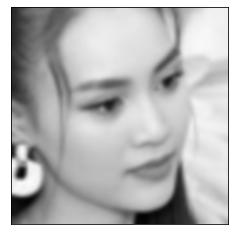

In [11]:
plt.imshow(Images[10], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [12]:
label = []
for imgfolder in os.listdir('drive/My Drive/Data_No_Aug/ML/'):
    for filename in os.listdir('drive/My Drive/Data_No_Aug/ML/' + imgfolder):
        label.append(imgfolder)
label = np.asarray(label)
label.shape

(500,)

## Chia thành 2 tập train và test theo tỉ lệ 8:2

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(Images, label, test_size = 0.2, random_state = 42)

### Khác

In [18]:
x_test.shape

(100, 80, 80)

## Model


In [19]:
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

Thêm các thư viện cần thiết

In [20]:
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [21]:
#flatten images.
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

In [22]:
from sklearn.model_selection import learning_curve, GridSearchCV

In [24]:
# doing cross validation to tune the params of SVC

param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(x_train, y_train)
print(grid.best_params_)

CPU times: user 1min 15s, sys: 15.6 s, total: 1min 30s
Wall time: 46.1 s
{'svc__C': 10, 'svc__gamma': 0.0005}


In [25]:
grid.best_score_

0.595

In [27]:
# pick the best model from the grid search above and use it to classify the test dataset
model = grid.best_estimator_
pred = model.predict(x_test)

In [28]:
from sklearn.metrics import  accuracy_score
from sklearn.metrics import classification_report

In [30]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

        Amee       0.71      0.65      0.68        26
        Jack       0.80      0.53      0.64        15
         MTP       0.43      0.43      0.43        14
       MyTam       0.54      0.65      0.59        20
        NDLN       0.50      0.56      0.53        25

    accuracy                           0.58       100
   macro avg       0.60      0.57      0.57       100
weighted avg       0.60      0.58      0.58       100



In [32]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(pred, y_test))

[[17  0  3  1  5]
 [ 0  8  3  2  2]
 [ 2  1  6  1  4]
 [ 1  1  2 13  3]
 [ 4  0  0  7 14]]


In [34]:
accuracy_score(pred, y_test)

0.58

### Nhận xét:
model cho kết quả dự đoán khá thấp do chỉ sử dụng PCA để trích chọn đặc trưng.

# Thử nghiệm bộ dữ liệu với CNN



In [101]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.optimizers import SGD
import keras
from keras.utils import np_utils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [ ]:
image_size = 80
def read_date(path):
  img = []
  label = []
  folders = os.listdir(path)
  for folder in os.listdir(path):
    i = 1
    for files in os.listdir(path+'/'+folder):
      files_name = path + '/'+folder+'/' + files
      
      print(files_name)
      print('STT: {}'.format(i))
      i += 1
      image = cv2.imread(files_name,0)
      
      image = cv2.resize(image, (image_size, image_size))
      images=np.reshape(image, image_size*image_size)
      img.append(images)
      label.append(folder)

  return np.asarray(img),np.asarray(label)

train_path = 'drive/My Drive/data_cnn/Train'
x_train, y_train = read_date(train_path)

test_path = 'drive/My Drive/data_cnn/Test'
x_test, y_test = read_date(test_path)

val_path = 'drive/My Drive/data_cnn/Validation'
x_val, y_val = read_date(val_path)

In [ ]:
test_path = 'drive/My Drive/data_cnn/Test'
x_test, y_test = read_date(test_path)

In [89]:
x_train.shape

(3280, 6400)

In [90]:
y_train.shape

(3280,)

In [91]:
y_val.shape

(720,)

## Data Augmentation

In [92]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X=LabelEncoder()
y_train = labelencoder_X.fit_transform(y_train)
y_test = labelencoder_X.transform(y_test)
y_val = labelencoder_X.transform(y_val)


In [93]:
x_train = x_train.reshape(x_train.shape[0], 80, 80, 1)
x_val = x_val.reshape(x_val.shape[0], 80, 80, 1)
x_test = x_test.reshape(x_test.shape[0], 80, 80, 1)

In [94]:
y_train = np_utils.to_categorical(y_train, 5)
y_val = np_utils.to_categorical(y_val, 5)
y_test = np_utils.to_categorical(y_test, 5)
print('Dữ liệu y ban đầu ', y_train[0])
print('Dữ liệu y sau one-hot encoding ',y_train[0])

Dữ liệu y ban đầu  [1. 0. 0. 0. 0.]
Dữ liệu y sau one-hot encoding  [1. 0. 0. 0. 0.]


In [ ]:
Y_test = y_test_cnn

## Xây dựng model

In [95]:
num_classes = 5

In [107]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape = (80,80,1), activation = 'relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units = num_classes, activation = 'softmax'))

In [ ]:
INIT_LR = 0.0001
EPOCHS = 50

In [109]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [110]:
H = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          batch_size=328, epochs=50, verbose=1)

Train on 3280 samples, validate on 720 samples
Epoch 1/50
3280/3280 [==============================] - 63s 19ms/step - loss: 2.0656 - accuracy: 0.3966 - val_loss: 12.1101 - val_accuracy: 0.2111
Epoch 2/50
3280/3280 [==============================] - 65s 20ms/step - loss: 1.2016 - accuracy: 0.5631 - val_loss: 18.2065 - val_accuracy: 0.2014
Epoch 3/50
3280/3280 [==============================] - 62s 19ms/step - loss: 0.9932 - accuracy: 0.6457 - val_loss: 10.1214 - val_accuracy: 0.2292
Epoch 4/50
3280/3280 [==============================] - 62s 19ms/step - loss: 0.7659 - accuracy: 0.7186 - val_loss: 9.8685 - val_accuracy: 0.2097
Epoch 5/50
3280/3280 [==============================] - 62s 19ms/step - loss: 0.6287 - accuracy: 0.7732 - val_loss: 8.2416 - val_accuracy: 0.2125
Epoch 6/50
3280/3280 [==============================] - 62s 19ms/step - loss: 0.4925 - accuracy: 0.8216 - val_loss: 6.6535 - val_accuracy: 0.2278
Epoch 7/50
3280/3280 [==============================] - 62s 19ms/step - lo

In [111]:
# 9. Đánh giá model với dữ liệu test set
score = model.evaluate(x_test, y_test)
print(score)

800/800 [==============================] - 5s 6ms/step
[1.5522848081588745, 0.6887500286102295]


### Dự đoán ảnh

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ninh-duong-lan-ngoc-bat-trend-len-ca-cay-do-hoa-tiet-sau-gian-cach-ly-22a84cb6.jpg to ninh-duong-lan-ngoc-bat-trend-len-ca-cay-do-hoa-tiet-sau-gian-cach-ly-22a84cb6 (1).jpg


In [ ]:
from PIL import Image
from google.colab.patches import cv2_imshow

In [ ]:
Images_pred = []
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  filename = fn
  img = cv2.imread(filename,0)
  img = cv2.resize(img, (80,80), interpolation = cv2.INTER_AREA)
  Images_pred.append(img)
Images_pred = np.asarray(Images_pred)
Images_pred.shape

User uploaded file "ninh-duong-lan-ngoc-bat-trend-len-ca-cay-do-hoa-tiet-sau-gian-cach-ly-22a84cb6.jpg" with length 43279 bytes


(1, 80, 80)

Giá trị dự đoán:  2


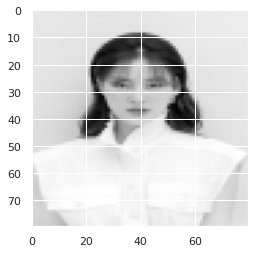

In [ ]:
plt.imshow(Images_pred[0].reshape(80,80), cmap='gray')

Predict = model.predict(Images_pred.reshape(1,80,80,1))
print('Giá trị dự đoán: ', np.argmax(Predict))